# ***Text Analysis*** on r/leaves <br> (a *subreddit* support community to help stop smoking marijuana)

In [2]:
# required libraries
import re
import spacy
import string
import warnings
import textacy.ke
import numpy as np
import pandas as pd
import datetime as dt
import streamlit as st
import plotly.express as px
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

from PIL import Image
from spacy import displacy
from tabulate import tabulate
from textblob import TextBlob
from string import punctuation
from collections import Counter
from nltk.corpus import stopwords
from spacy.matcher import Matcher
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize

In [3]:
# Load the local files
rleaves = pd.read_csv('rleaves.csv', encoding='utf-8')

# Cleaning up the corpus
sp = spacy.load('en_core_web_sm')

# a custom function for complete text cleanup
def cleanup1(text):
    text = text.lower() # lowers the corpus
    text = re.sub('http\S+', ' ', str(text)) # removes any url
    text = re.sub('n\'t\s', ' not ', str(text))
    text = re.sub('-(?<!\d)', ' ', str(text)) # removing hyphens from numbers
    text = sp(text) # apply spacy model
    text = [w.text for w in text if not w.is_stop] # tokenize and remove stop words
    text = sp(' '.join(text)) # join words and apply spacy model again 
    text = [w.lemma_ for w in text] # lemmatizes the words
    stopwords_extra = ['im', 'na', 'u', 'ill', '10184285', '179180', 'as', 'oh', 'av', 'wo', 'nt', 'p', 'm', 'ta', '10000', '6000']
    text = [word for word in text if not word in stopwords_extra] # remove additional unnecessary words
    text = ' '.join(text)  # join the words back together  
    text = text.translate(str.maketrans('', '', string.punctuation)) # removes all punctuation
    text = re.sub('[^\w\s,]', ' ', str(text)) # removes emoticon and other non characters
    text = re.sub('x200b', ' ', str(text)) # removing zero-width space characters
    text = re.sub(' cannabi ', ' cannabis ', str(text))
    return ' '.join([token for token in text.split()]) # removes trailing whitespaces

# a custom function to change UTC time and split days and hours
def change_time(utc):
    day = dt.datetime.fromtimestamp(utc).strftime('%A')
    hour = dt.datetime.fromtimestamp(utc).strftime('%I %p')
    return pd.Series([day, hour])

# apply preprocessing function
rleaves[['day', 'hour']] = rleaves['time'].apply(change_time)
rleaves['raw'] = pd.DataFrame(rleaves['raw'].apply(cleanup1))

## Questions
#### What are the top 200 words in rleaves subreddit?

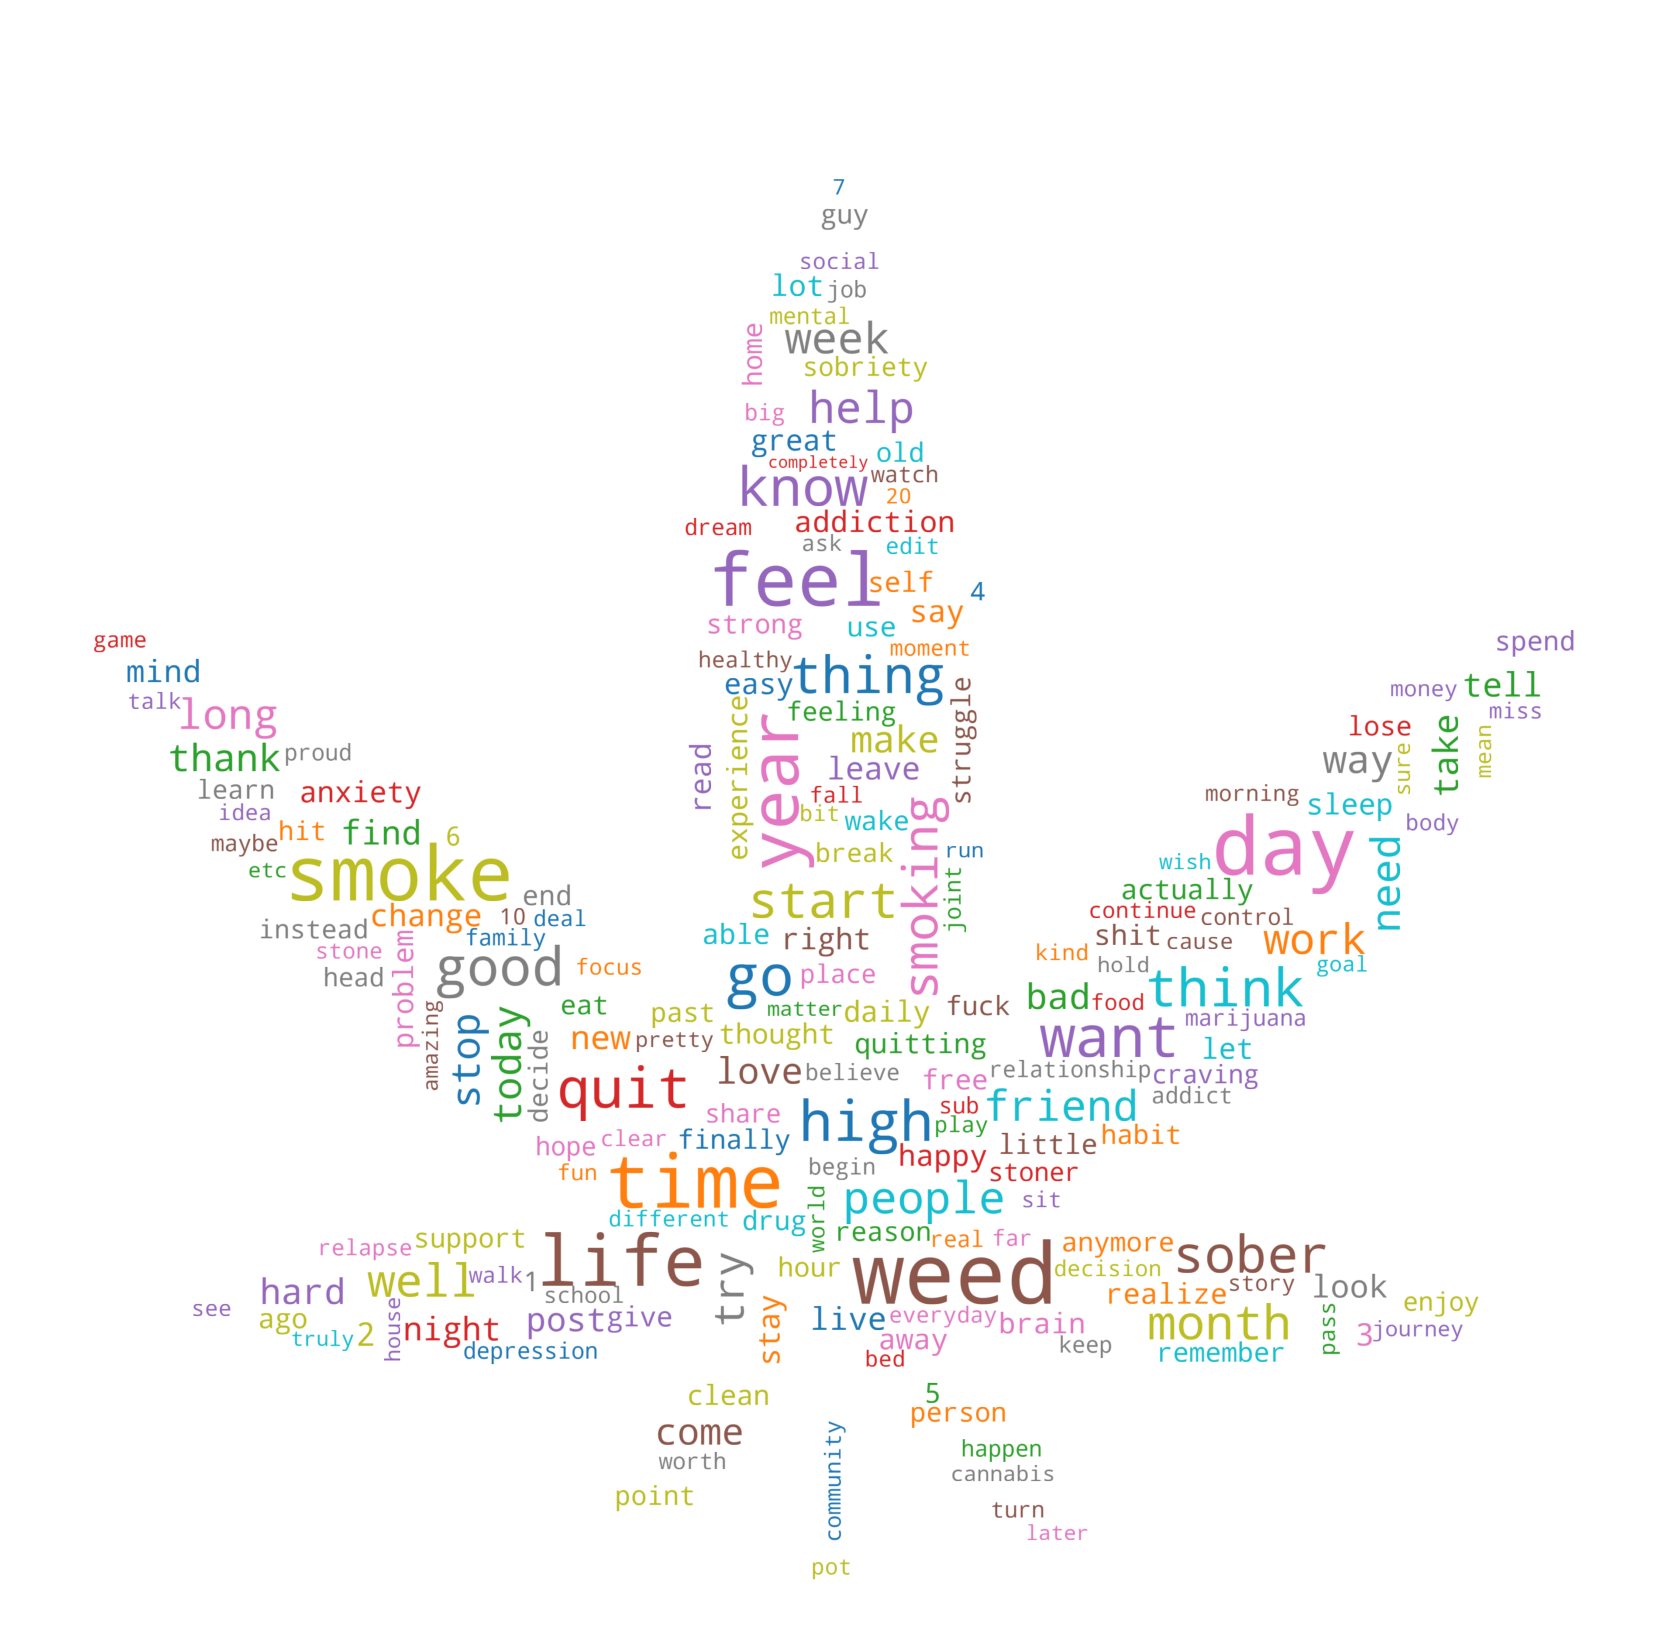

In [4]:
# WordCloud
wordcloud_text = ' '.join(rleaves['raw'].tolist())

def plot_cloud(wordcloud):    
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

# WordCloud with Mask
mask = np.array(Image.open('marijuana.png'))
wordcloud_user = WordCloud(width=300, height=200, background_color='rgba(255, 255, 255, 0)', mode='RGBA', colormap='tab10', collocations=False, mask=mask, include_numbers=True).generate(wordcloud_text)

#wordcloud_user.to_file("wordcloud_user_leaves.png")
plot_cloud(wordcloud_user)

#### What are the top 100 words in rleaves subreddit?

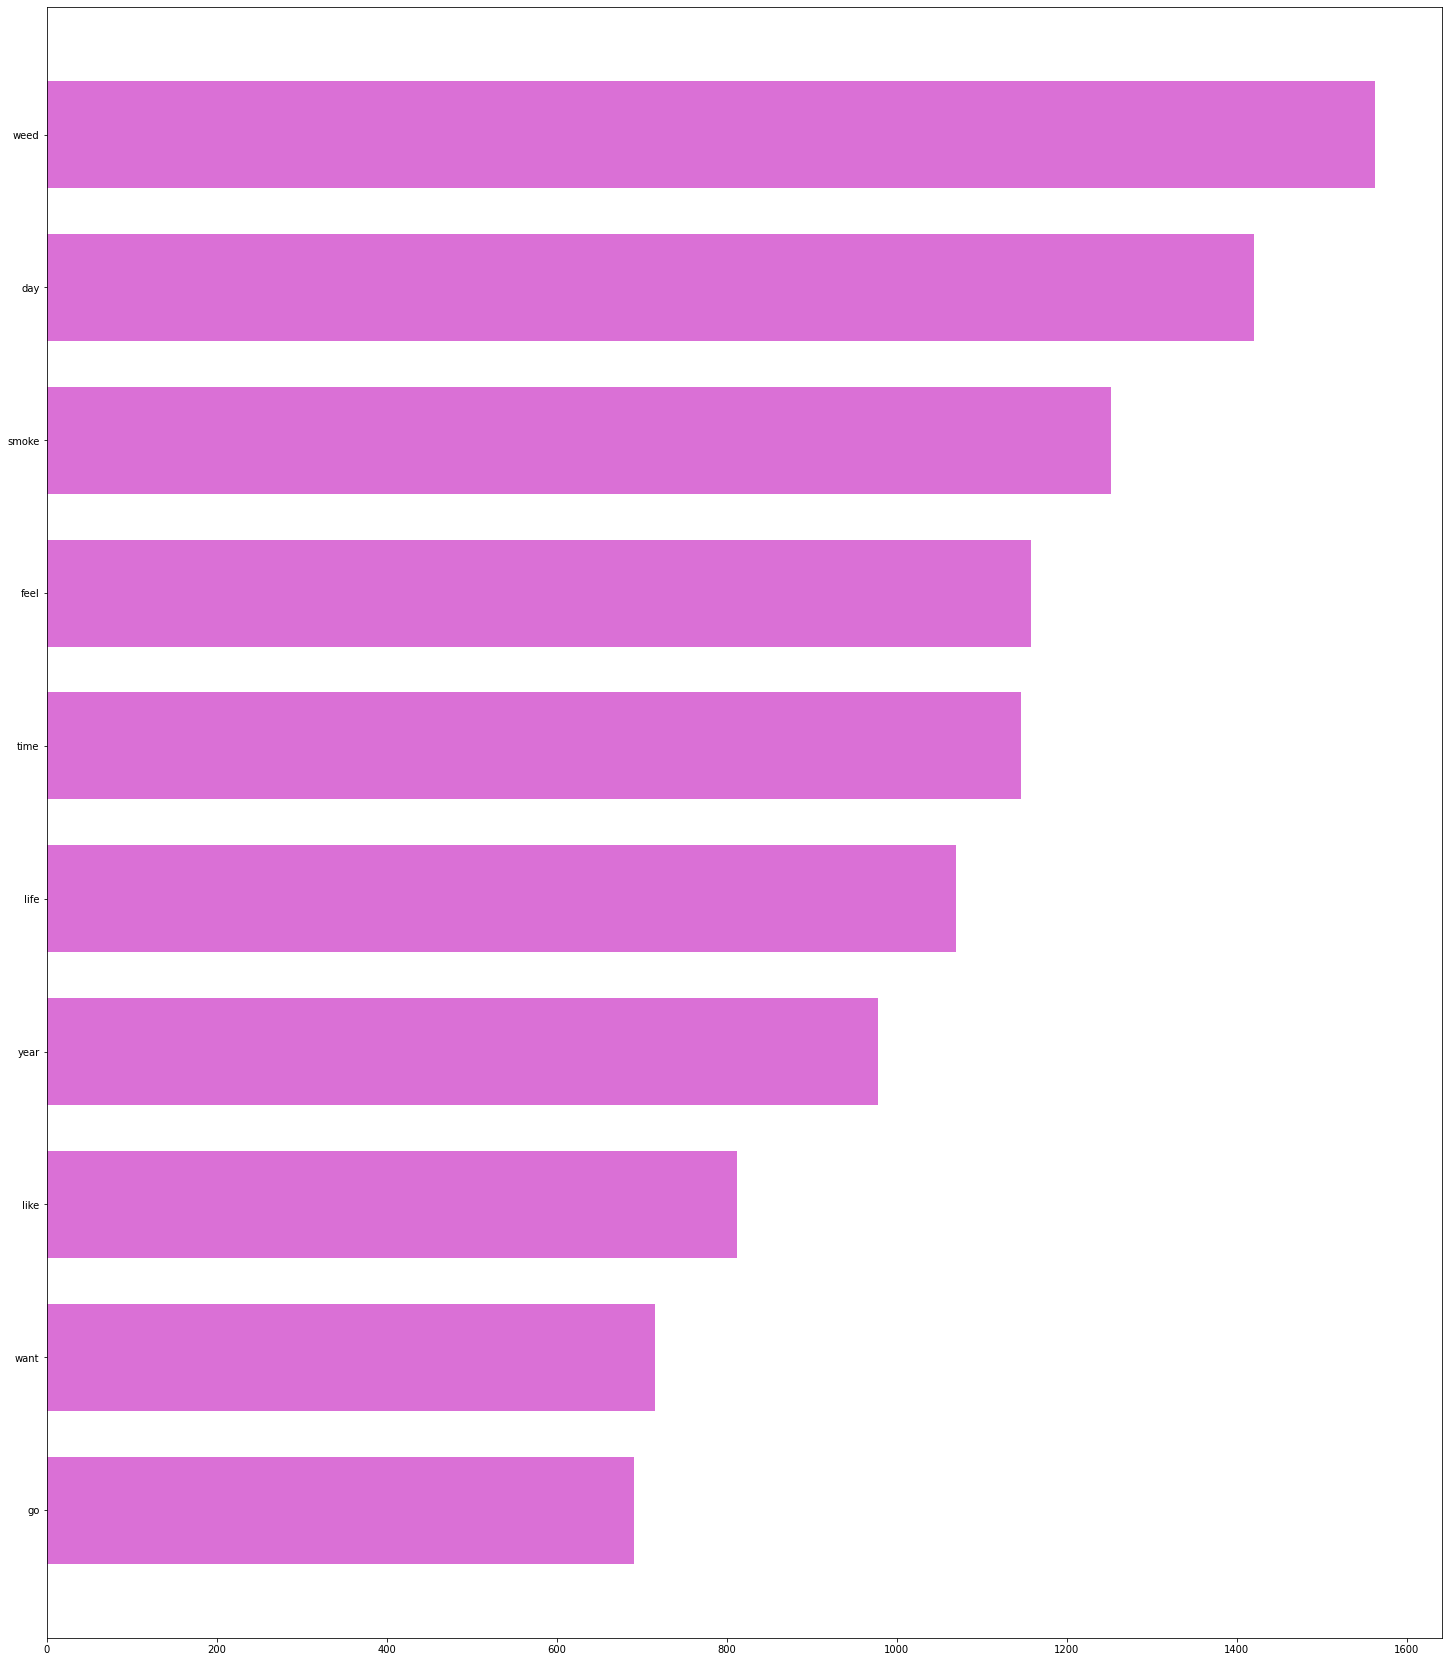

In [5]:
# Most common words
top_words = Counter(' '.join(rleaves['raw']).split()).most_common(10)
top_words = pd.DataFrame(top_words, columns=['word', 'count']).sort_values(by='count', ascending=True)
plt.style.use('seaborn-bright')
plt.figure(figsize=(25, 30))
plt.barh(top_words['word'], top_words['count'], height= 0.7, align='center', color='orchid') 
plt.show()

#### What do we know about the authors of the posts?

In [6]:
q1a = round(rleaves['author'].nunique()/rleaves.shape[0]*100, 2)
q1b = rleaves['author'].value_counts().loc[rleaves['author'].value_counts().values > 1].shape[0]
print(str(q1a) + '% of the posts are by unique authors.')
print(q1b, 'authors have more than one post.')

81.23% of the posts are by unique authors.
77 authors have more than one post.


#### What day of the week had more posts than the others?

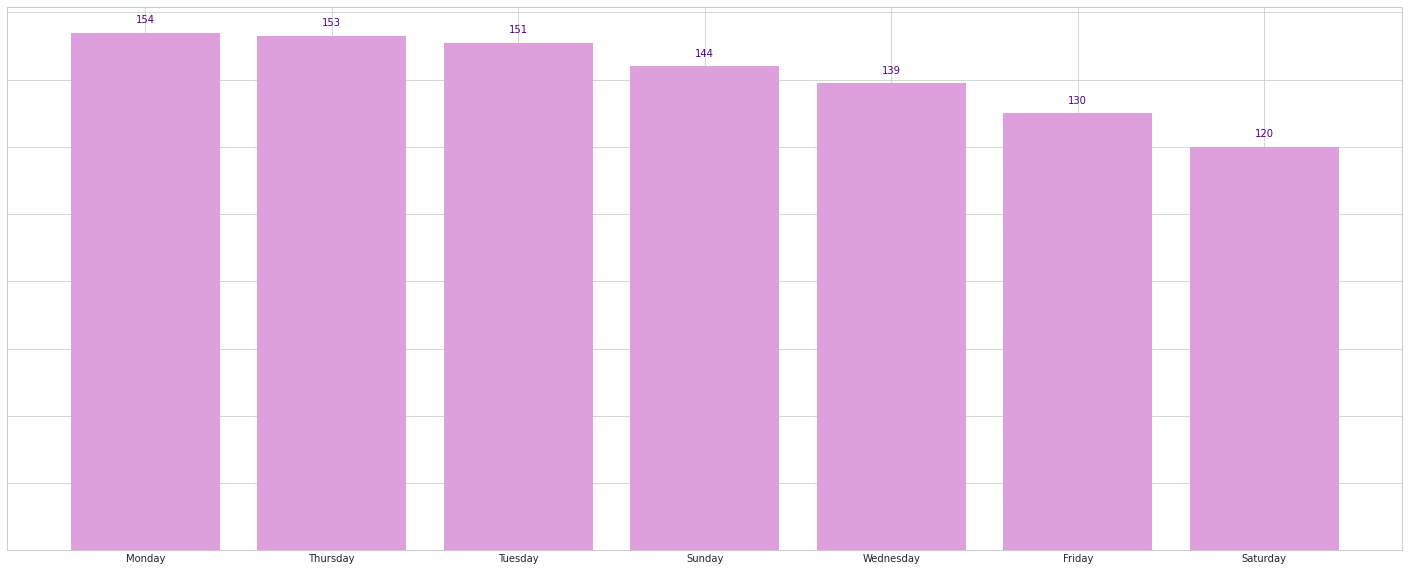

In [7]:
fig1 = pd.DataFrame(rleaves['day'].value_counts()).reset_index().rename(columns={"index": "day", "day": "count"})
fig1 = fig1.convert_dtypes()
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25, 10))
plt.bar(fig1['day'], fig1['count'], color='plum')
plt.tick_params(labelleft=False)
for x, y in zip(fig1['day'], fig1['count']):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 color='indigo') 
plt.show()

#### What time of the day had more posts than the others?

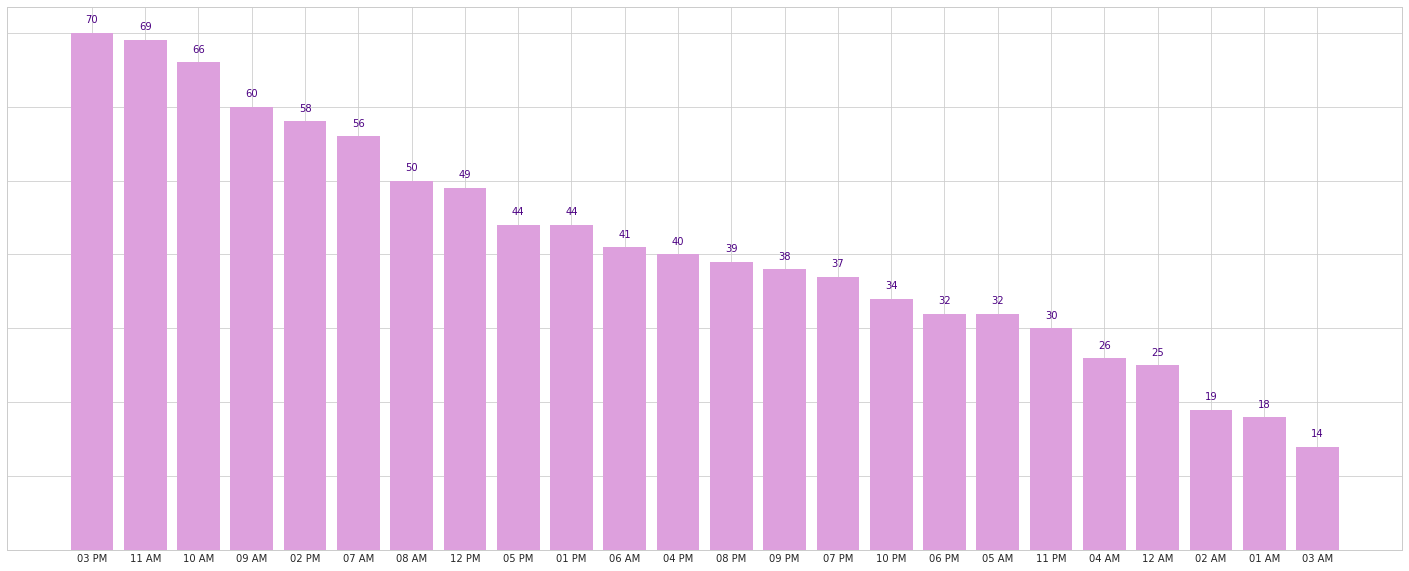

In [8]:
fig2 = pd.Series(rleaves['hour'].value_counts(), name='count')
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25, 10))
plt.bar(fig2.index, fig2.values, color='plum')
plt.tick_params(labelleft=False)
for x, y in zip(fig2.index, fig2.values):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 color='indigo') 
plt.show()

#### Which day during an author's journey had the most post?

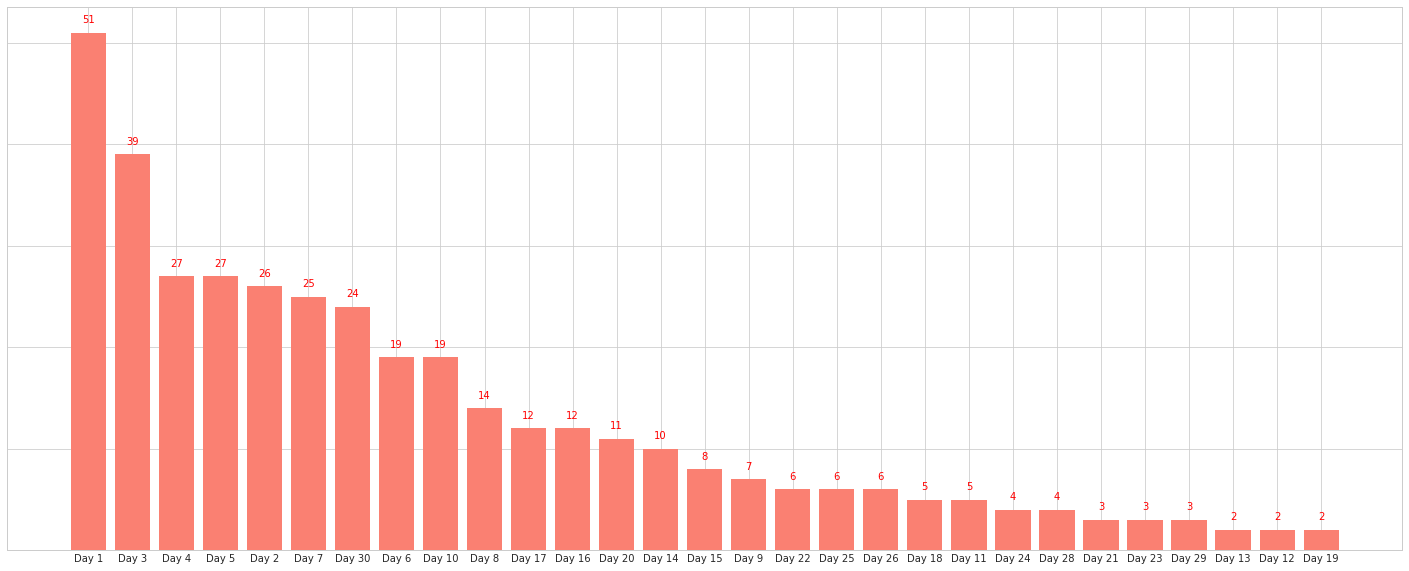

In [9]:
day = list(rleaves.raw.str.findall(r'\d+\s*day[s\s]|\s*day\s*\d+'))
day = [int(item) for item in re.findall(r'\d+', str(day))]
day = pd.DataFrame([[x, day.count(x)] for x in set(day)]).rename(columns={0:'day', 1:'count'})
day_week = day.groupby(pd.cut(day['day'], np.arange(0, day['day'].max(), 7))).sum()

day = day.loc[(day['day'] > 0) & (day['day'] < 31)]
day['day'] = 'Day ' + day['day'].astype(str)
day.sort_values(by='count', ascending=False, inplace=True) 

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25, 10))
plt.bar(day['day'], day['count'], color='salmon')
plt.tick_params(labelleft=False)
for x, y in zip(day['day'], day['count']):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 color='red') 
plt.show()

#### Which week during an author's journey had the most post?

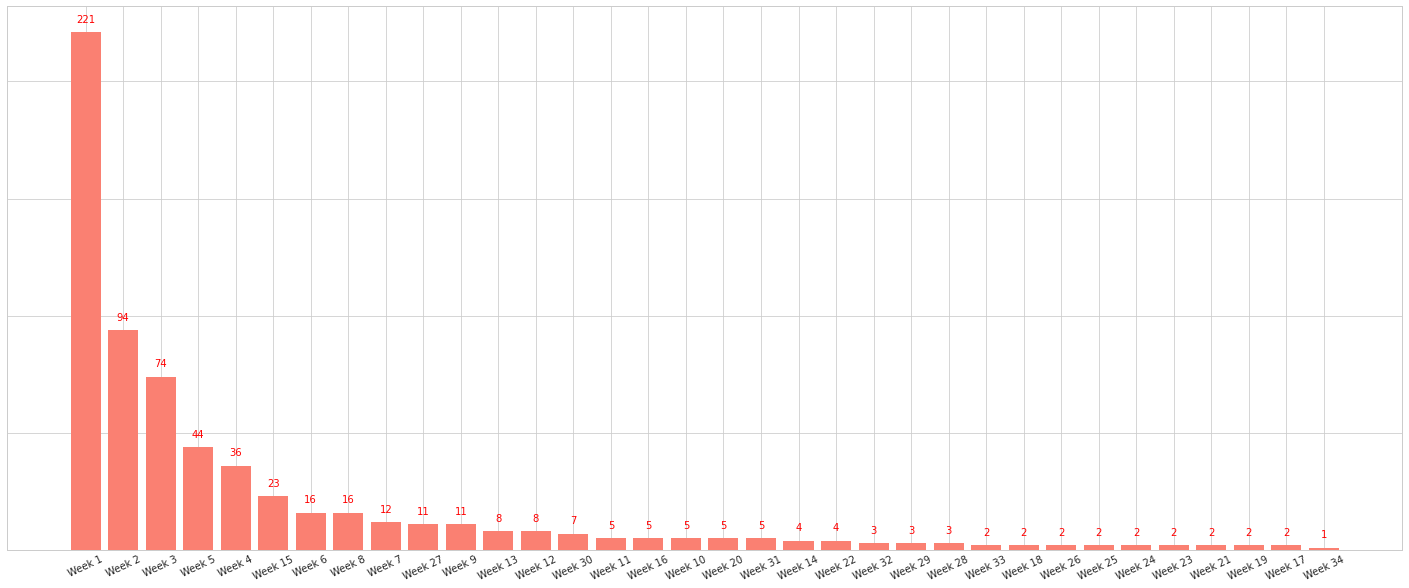

In [10]:
day_week = day_week.drop(['day'], axis=1).reset_index(drop=True)
day_week = day_week[day_week['count'] > 1]
day_week.index = ['Week %s' %i for i in range(1, len(day_week) + 1)]

week = list(rleaves.raw.str.findall(r'\d+\s*week[s\s]|\s*week\s*\d+'))
week = [int(item) for item in re.findall(r'\d+', str(week))]
week = pd.DataFrame.from_dict(Counter(week), orient='index').rename(columns={0:'w_count'}).sort_index(ascending=True)
week = week[week.index < 35]
week.index = 'Week ' + week.index.astype(str)
week = pd.concat([day_week, week], axis=1).fillna(0).reset_index()
week[['count','w_count']] = week[['count','w_count']].astype(int)
week['total_count'] = week['count'] + week['w_count']
week.sort_values(by='total_count', ascending=False, inplace=True)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25, 10))
plt.bar(week['index'], week['total_count'], color='salmon')
plt.tick_params(labelleft=False)
for x, y in zip(week['index'], week['total_count']):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 color='red')
plt.xticks(rotation=25)
plt.show()

#### Which month during an author's journey had the most post?

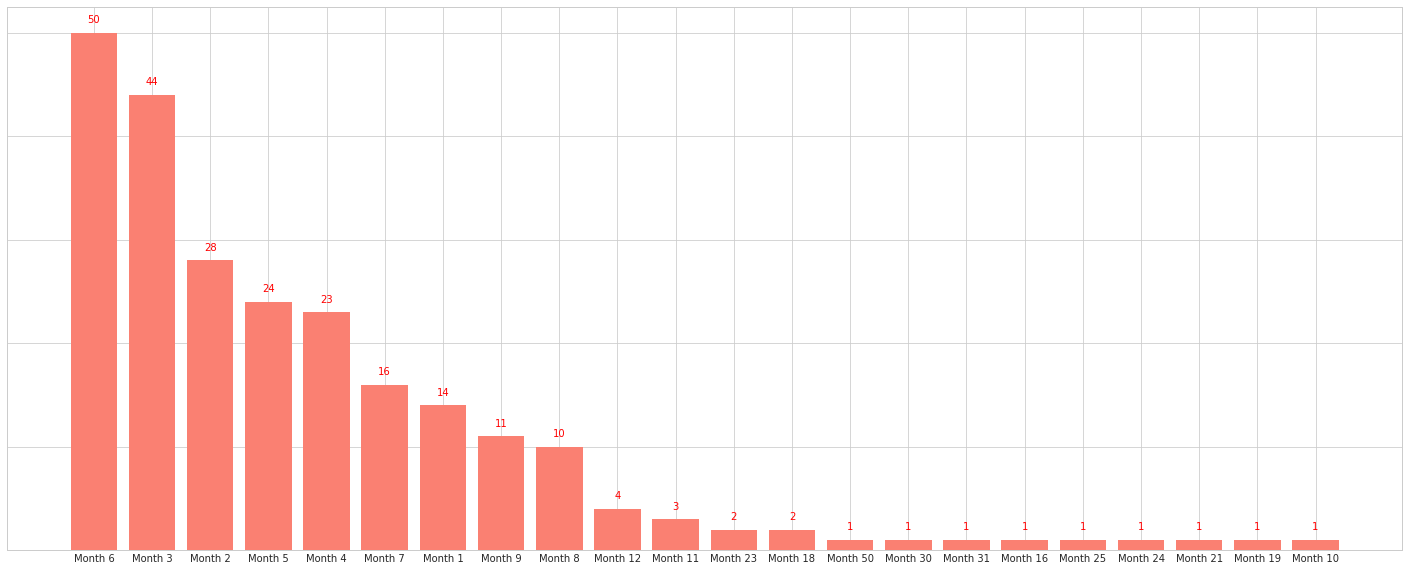

In [11]:
month = list(rleaves.raw.str.findall(r'\d+\s*month[s\s]|\s*month\s*\d+'))
month = [int(item) for item in re.findall(r'\d+', str(month))]
month = pd.DataFrame([[x, month.count(x)] for x in set(month)]).rename(columns={0:'month', 1:'count'}).sort_values(by='count', ascending=False)
month = month[month['month'] < 200]
month['month'] = 'Month ' + month['month'].astype(str)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25, 10))
plt.bar(month['month'], month['count'], color='salmon')
plt.tick_params(labelleft=False)
for x, y in zip(month['month'], month['count']):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 color='red')
plt.show()

#### Which year during an author's journey had the most post?

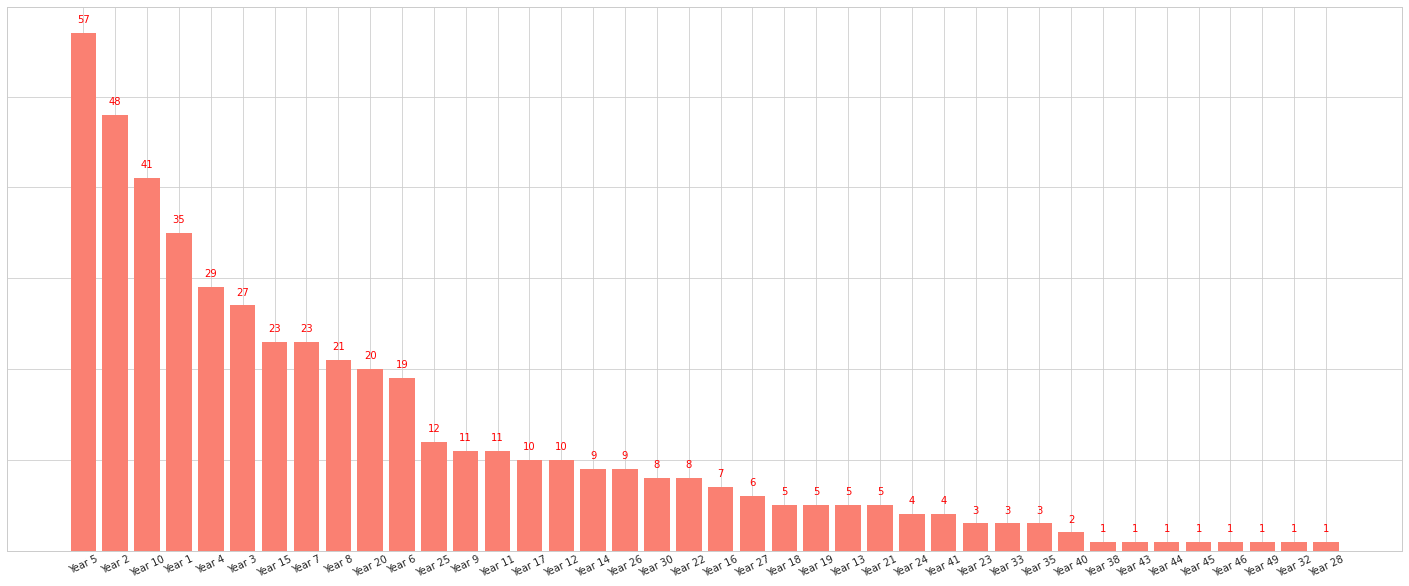

In [12]:
year = list(rleaves.raw.str.findall(r'\d+\s*ye?a?r[s\s]*')) 
year = [int(item) for item in re.findall(r'\d+', str(year))]
year = pd.DataFrame([[x, year.count(x)] for x in set(year)]).rename(columns={0:'year', 1:'count'}).sort_values(by='count', ascending=False)
year = year.loc[(year['year'] < 50) & (year['year'] > 0)]
year['year'] = 'Year ' + year['year'].astype(str)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25, 10))
plt.bar(year['year'], year['count'], color='salmon')
plt.tick_params(labelleft=False)
for x, y in zip(year['year'], year['count']):
    label = "{:.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 color='red')
plt.xticks(rotation=25)    
plt.show()

#### What are the most important keywords?

In [13]:
%%time
# Load a spacy model, which will be used for all further processing.
en = textacy.load_spacy_lang('en_core_web_sm')
text = ' '.join(rleaves['raw'])

#convert the text into a spacy document.
doc = textacy.make_spacy_doc(text, lang=en)
print(tabulate(textacy.ke.yake(doc, ngrams=2, window_size=4, topn=10), tablefmt='grid', headers=["Most Important Keywords", "YAKE! Score"]))

2021-01-25 19:33:55.951 INFO    textacy.spacier.core: loaded 'en_core_web_sm' spaCy language pipeline


+---------------------------+---------------+
| Most Important Keywords   |   YAKE! Score |
+===========================+===============+
| smoke weed                |     0.0966792 |
+---------------------------+---------------+
| day day                   |     0.12083   |
+---------------------------+---------------+
| day sober                 |     0.121298  |
+---------------------------+---------------+
| year smoke                |     0.128374  |
+---------------------------+---------------+
| day smoke                 |     0.133697  |
+---------------------------+---------------+
| time day                  |     0.140721  |
+---------------------------+---------------+
| year sober                |     0.142369  |
+---------------------------+---------------+
| year weed                 |     0.142645  |
+---------------------------+---------------+
| time smoke                |     0.143966  |
+---------------------------+---------------+
| weed day                  |     

In [14]:
# Creating for features 
actions = pd.DataFrame(rleaves['raw'])
actions['num'] = np.where(actions['raw'].str.contains('\d+'), True, False) # looks for all numbers
actions['period'] = np.where(actions['raw'].str.contains('\s*days* |\s*months* |\s*weeks* |\s*ye?a?rs* '), True, False) # looks for time
actions = actions.loc[(actions['num'] == True) & (actions['period'] == True)] # filter only those rows
actions['day'] = np.where(actions['raw'].str.contains('\d+\s*day[s\s]|\s*day\s*\d+'), True, False) # indicates whether number is day or not
actions['week'] = np.where(actions['raw'].str.contains('\d+\s*week[s\s]|\s*week\s*\d+'), True, False) # indicates whether number is week or not
actions['month'] = np.where(actions['raw'].str.contains('\d+\s*month[s\s]|\s*month\s*\d+'), True, False) # indicates whether number is month or not
actions['year'] = np.where(actions['raw'].str.contains('\d+\s*ye?a?r[s\s]*'), True, False) # indicates whether number is year or not
actions['nums'] = actions['raw'].str.findall('\d+') # strips all the number
actions['nums'] = [[int(n) for n in sub] for sub in actions['nums']] # convert all numbers to int
actions['nums'] = actions['nums'].apply(lambda x: min(x)) # keep only the smallest numbers
actions = actions.loc[(actions['nums'] > 0) & (actions['nums'] < 800)] # remove outliers
actions[['day', 'week', 'month', 'year']] = actions[['day', 'week', 'month', 'year']].cumsum(axis=1).cumsum(axis=1) == 1 # keeping only first trues
actions.drop(columns=['num', 'period'], inplace=True) # drop columns

In [15]:
# a function to find ****
def find_actions(text):
    matcher = Matcher(sp.vocab)
    pattern = [{'DEP': 'amod'},
                {'POS': 'NOUN'}]
    matcher.add("find_actions", None, pattern)
    doc = sp(''.join(text))
    matches = matcher(doc)
    acts = []
    for match_id, start, end in matches:
        span = doc[start:end]
        acts.append(span.text) 
    return acts

# apply function
rleaves['actions'] = rleaves['raw'].apply(find_actions)

In [16]:
rleaves['actions'][0]

['tough sense',
 'clear mind',
 'easy place',
 'pass thinking',
 'crazy tangent',
 'hard mind',
 'crazy tangent',
 'meditate experience',
 'crazy tangent',
 'long time',
 'ambitious starting',
 'comfortable position',
 'black room',
 'mental note',
 'obsessed work',
 'second week',
 'actual sensation',
 'moving nose',
 'repetitive minute',
 'repetitive idea',
 'chatty thought',
 'peaceful repetition',
 'repetitive place',
 'frustrated time',
 'peaceful repetition',
 'peaceful repetition',
 'inner thought',
 'few time',
 'inner dialog',
 'automatic influence']

In [17]:
b = pd.DataFrame(rleaves['actions'][1], columns=['actions'])
b['polarity'] = b['actions'].apply(lambda x: TextBlob(x).polarity)
b['subjective'] = b['actions'].apply(lambda x: TextBlob(x).subjectivity)

In [20]:
rleaves['author'].nunique()

805